In [146]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from torchvision.models import resnet18, ResNet18_Weights

In [147]:
# Ustawienie urządzenia: jeśli dostępne CUDA, użyj GPU, w przeciwnym razie CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    print(f"CUDA jest dostępne. Urządzenie GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA nie jest dostępne.")

tensor = torch.randn(3, 3)
print(f"Przed przeniesieniem na GPU: {tensor.device}")

# Przenosimy tensor na GPU
tensor = tensor.to('cuda')  # Lub tensor.cuda()
print(f"Po przeniesieniu na GPU: {tensor.device}")

cuda
CUDA jest dostępne. Urządzenie GPU: NVIDIA GeForce RTX 3060
Przed przeniesieniem na GPU: cpu
Po przeniesieniu na GPU: cuda:0


In [190]:
batch_size = 16
learning_rate = 0.0001
input_size = (438, 256)  # Rozdzielczość obrazów
num_classes = 16  # Liczba klas
epochs = 70
mel_bands = 512
n = 12313 #wersja modelu

In [191]:
if learning_rate == 0.001:
    lr = 'med'
elif learning_rate == 0.0001:
    lr = 'small'
elif learning_rate == 0.01:
    lr = 'big'

In [204]:
# model_path = f'D:/studia/bird_sound_recognition/model training/models/{mel_bands}/best_model_{mel_bands}_LR-{lr}_{n}.pth'
model_path = 'D:\studia/bird_sound_recognition\model training\models/512/best_model_512_LR-small_4.pth'

In [166]:
def train_model(model, train_loader, val_loader, criterion, optimizer, path=model_path, num_epochs=epochs, stop_threshold_train=1e-4, stop_threshold_test=0.1, min_improvement_epochs=10):
    train_losses, val_losses = [], []
    best_acc = 0.0
    best_model_state = None
    model.to(device)

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    no_improvement_count = 0  # Licznik epok bez poprawy

    prev_train_loss = None
    prev_val_loss = None
    stagnation_count_train = 0
    stagnation_count_val = 0
    overfitting = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Dokładność
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        # Testowanie na danych walidacyjnych
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Train Loss: {epoch_loss:.4f} - Train Accuracy: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc:.4f}")

        # Sprawdzanie i zapisywanie najlepszego modelu
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            best_model_state = model.state_dict()
            print(f"Zapisano najlepszy model w epoce {best_epoch} z dokładnością: {best_acc:.4f}")

        # Sprawdzanie stagnacji w train_loss i val_loss
        if prev_train_loss is not None and prev_val_loss is not None:
            train_loss_change = abs(prev_train_loss - epoch_loss)
            val_loss_change = abs(prev_val_loss - val_loss)

            if train_loss_change < stop_threshold_train:
                stagnation_count_train += 1
                print(f"Minimalne zmiany w Train Loss ({train_loss_change:.6f}) przez {stagnation_count_train} epok.")
            else:
                stagnation_count_train = 0  # Resetowanie licznika

            if val_loss_change < stop_threshold_test:
                stagnation_count_val += 1
                print(f"Minimalne zmiany w Val Loss ({val_loss_change:.6f}) przez {stagnation_count_val} epok.")
            else:
                stagnation_count_val = 0  # Resetowanie licznika

            if prev_val_loss - val_loss < 0:
                overfitting += 1
                print(f"Rosnący Val Loss ({val_loss:.6f}, {prev_val_loss}) przez {overfitting} epok.")
            else:
                overfitting = 0  # Resetowanie licznika

            if overfitting >= 5 or stagnation_count_val >= min_improvement_epochs or stagnation_count_train >= min_improvement_epochs:
                print(f"Uczenie zatrzymane po {epoch + 1} epokach z powodu minimalnych zmian w loss.")
                break

        # Zapamiętanie poprzednich wartości
        prev_train_loss = epoch_loss
        prev_val_loss = val_loss

    if best_model_state is not None:
        torch.save(best_model_state, path)
        print(f"Najlepszy model został zapisany jako {mel_bands}_LR-{lr}_{n}.pth")

    print("Training complete.")
    return history

In [209]:
def validate_model(model, val_loader, criterion, best_model_path=model_path,
                   output_file=f'D:/studia/bird_sound_recognition/model training/models/{mel_bands}/validation-results_LR-{lr}_{n}.txt'):
    # Wczytanie polskich nazw gatunków
    with open('D:/studia/bird_sound_recognition/spec_name_pl.json', 'r', encoding='utf-8') as f:
        species_pl_names = json.load(f)

    if best_model_path:
        model.load_state_dict(torch.load(best_model_path))


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Dokładność
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Do raportu klasyfikacji
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)

    # Generowanie raportu klasyfikacji
    report = classification_report(all_labels, all_preds, target_names=val_loader.dataset.classes)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print("\nClassification Report:\n", report)

    # Zapis do pliku
    with open(output_file, "w") as f:
        f.write(f"Validation Loss: {avg_val_loss:.4f}\n")
        f.write(f"Validation Accuracy: {val_acc:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)

    # Macierz pomyłek w procentach
    cm = confusion_matrix(all_labels, all_preds)

    # Konwersja na procenty
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Przygotowanie nazw klas w języku polskim
    pl_classes = [
        species_pl_names[i].title() for i in range(len(val_loader.dataset.classes))
        if i < len(species_pl_names)
    ]
    sns.set_context("notebook", font_scale=1.5)  # Zwiększa ogólnie wszystkie czcionki na wykresie
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt=".0f", cmap="BuPu",
                xticklabels=pl_classes,
                yticklabels=pl_classes)
    plt.xlabel("Przewidywane etykiety")
    plt.ylabel("Prawdziwe etykiety")
    plt.title("Macierz Pomyłek (Procent)")
    plt.tight_layout()
    os.makedirs('conf_matrices', exist_ok=True)
    plt.savefig(f'results/conf_matrices/conf_{mel_bands}_LR-{lr}_{n}.png', dpi=300)
    plt.show()
    plt.close()

In [194]:
def generate_plots(history, train_loader, val_loader, device):
    # Generowanie wykresu funkcji straty (train_loss vs val_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Strata w treningu')
    plt.plot(history['val_loss'], label='Strata w walidacji')
    plt.title("Funkcja straty")
    plt.xlabel("Epoki")
    plt.ylabel("Wartość funkcji straty")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'results/loss/loss_{mel_bands}_LR-{lr}_{n}.png', dpi=300)
    plt.show()

    # Generowanie wykresu dokładności (train_accuracy vs val_accuracy)
    plt.figure(figsize=(10, 5))
    plt.plot(history['accuracy'], label='Dokładność treningowa')
    plt.plot(history['val_accuracy'], label='Dokładność walidacji')
    plt.title("Wartość dokładności w każdej epoce")
    plt.xlabel("Epoki")
    plt.ylabel("Dokładność")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'results/accuracy/acc_{mel_bands}_LR-{lr}_{n}.png', dpi=300)
    plt.show()

In [195]:
# Transformacje danych
transform = transforms.Compose([
    transforms.Resize((438, 256)),  # Dopasowanie do rozdzielczości obrazów
    transforms.ToTensor(),         # Konwersja na tensory
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizacja
])

In [196]:
data_dir = f"D:/studia/bird_sound_recognition/data/training2/split_{mel_bands}-mel"
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')


In [197]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [198]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [199]:
# Model ResNet
model = resnet18()  # Wczytanie modelu z wagami domyślnymi
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Dopasowanie do liczby klas
model = model.to(device)

In [173]:
# Strata i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [174]:
# Trenowanie modelu
history = train_model(model, train_loader, val_loader, criterion, optimizer, path=model_path, num_epochs=epochs)

Epoch 1/70


KeyboardInterrupt: 

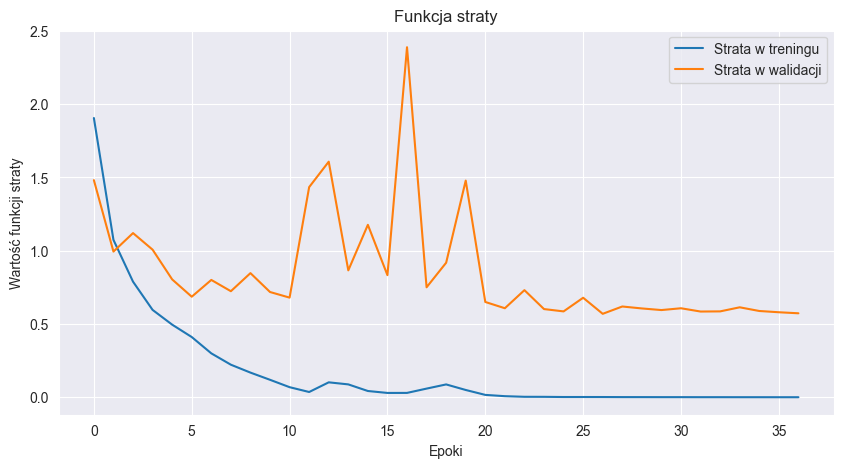

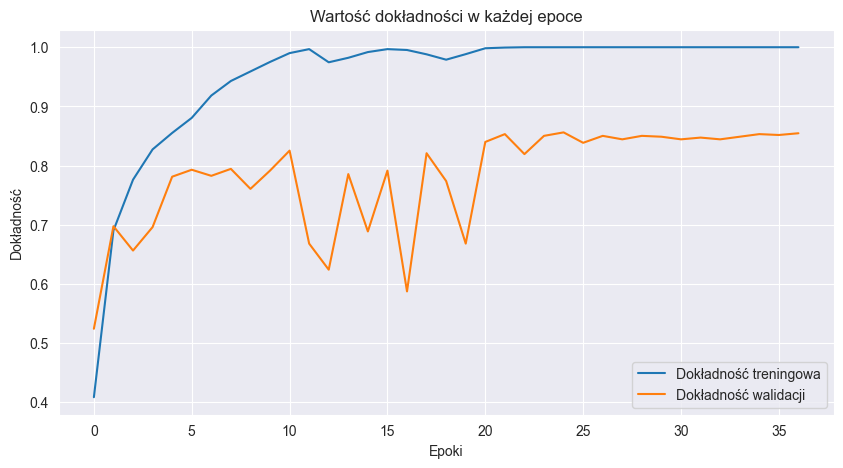

In [161]:
# Generowanie wykresów
generate_plots(history, train_loader, val_loader, device)

C:\Users\zuzan\AppData\Local\Temp\ipykernel_29760\100878392.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Validation Loss: 0.5058, Validation Accuracy: 0.8764

Classification Report:
                         precision    recall  f1-score   support

       Alauda-arvensis       0.85      0.93      0.89        30
             Apus-apus       0.97      0.97      0.97        31
   Bombycilla-garrulus       0.93      0.93      0.93        28
       Ciconia-ciconia       1.00      0.70      0.82        10
         Corvus-cornix       0.72      0.93      0.81        30
   Cyanistes-caeruleus       0.93      0.93      0.93        30
     Fringilla-coelebs       0.87      0.87      0.87        30
       Hirundo-rustica       0.81      0.73      0.77        30
 Luscinia-megarhynchos       0.87      0.87      0.87        31
     Passer-domesticus       0.96      0.80      0.87        30
  Phoenicurus-ochruros       0.84      0.87      0.85        30
Phylloscopus-collybita       0.87      0.90      0.89        30
         Picus-viridis       0.90      0.84      0.87        31
 Streptopelia-decaocto   

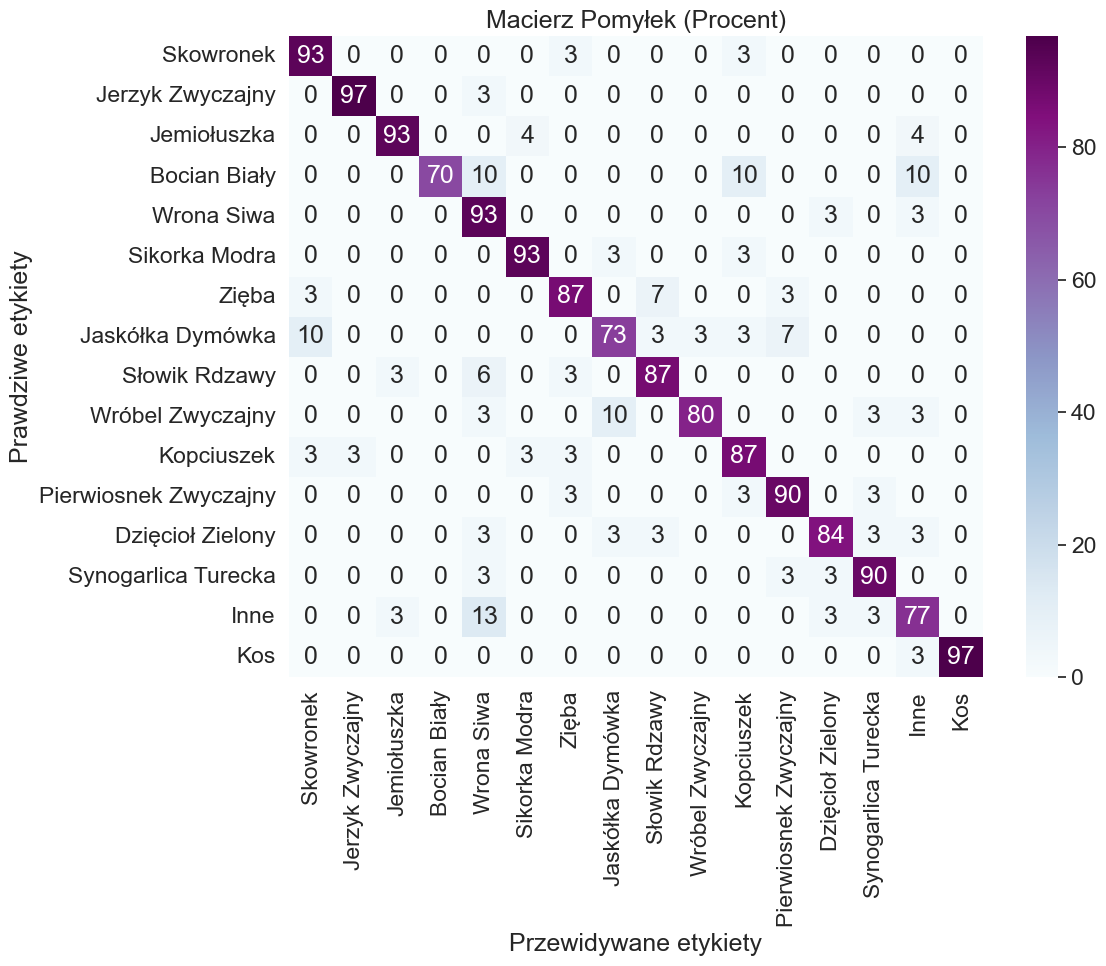

In [210]:
# Walidacja modelu
validate_model(model, test_loader, criterion)